# Setting kaggle

In [ ]:
# to upload files
#from google.colab import files

# install Kaggle library
# !pip list
# !pip install -q kaggle

In [ ]:
# upload kaggle API key file
#uploaded = files.upload()

In [0]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

# Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten

from PIL import Image
import requests
from io import BytesIO

import json
import zipfile

from datetime import datetime
from tqdm import tqdm, auto
import shutil
import os
import gc
import warnings
warnings.filterwarnings("ignore")

from shutil import copyfile
from shutil import rmtree

# Load Data

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (PNEUMONIA/NORMAL). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [ ]:
# download dataset <owner>/<dataset-name>
#!kaggle datasets download paultimothymooney/chest-xray-pneumonia

In [11]:
os.makedirs('images/NORMAL', exist_ok=True)
os.makedirs('images/PNEUMONIA', exist_ok=True)

base_dir = '/kaggle/input/chest-xray-pneumonia'
test_img_dir = os.path.join(base_dir, 'chest_xray/test')
train_img_dir = os.path.join(base_dir, 'chest_xray/train')
val_img_dir = os.path.join(base_dir, 'chest_xray/val')

# Join train, test, and val files based on their class
for img_dir in [test_img_dir, train_img_dir, val_img_dir]:
    for dirname, _, filenames in os.walk(img_dir):
        for i, file in enumerate(filenames):
            img_class = dirname.split('/')[6]
            copyfile(os.path.join(dirname, file), 'images/' + img_class + '/' + file)

In [17]:
#There's an imbalanced in data
for dirname, _, filenames in os.walk('images'):
    if(len(dirname.split("/")) > 1):
        print(dirname.split[6] + " has " + str(len(filenames)) + " files")

images/NORMAL has 1583 files
images/PNEUMONIA has 4273 files


In [22]:
#rmtree('train') # Remove existing, if re-run
#rmtree('test') # Remove existing, if re-run

## Split into train, test, and val dataset
os.makedirs('train/NORMAL', exist_ok=True)
os.makedirs('train/PNEUMONIA', exist_ok=True)
os.makedirs('test/NORMAL', exist_ok=True)
os.makedirs('test/PNEUMONIA', exist_ok=True)
os.makedirs('val/NORMAL', exist_ok=True)
os.makedirs('val/PNEUMONIA', exist_ok=True)

# Split NORMAL into train and val dataset
train, val = train_test_split(os.listdir('images/NORMAL'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('train/NORMAL/', img))
for img in val:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('val/NORMAL/', img))

# Split PNEUMONIA into train and val dataset
train, val = train_test_split(os.listdir('images/PNEUMONIA'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('train/PNEUMONIA/', img))
for img in val:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('val/PNEUMONIA/', img))
    
# Split NORMAL into train and test dataset
train, test = train_test_split(os.listdir('train/NORMAL'), 
                               test_size=0.2, 
                               random_state=42)
for img in test:
    copyfile(os.path.join('train/NORMAL/', img), 
             os.path.join('test/NORMAL/', img))
    os.remove(os.path.join('train/NORMAL/', img))
    
# Split PNEUMONIA into train and test dataset
train, test = train_test_split(os.listdir('train/PNEUMONIA'), 
                               test_size=0.2, 
                               random_state=42)
for img in test:
    copyfile(os.path.join('train/PNEUMONIA/', img), 
             os.path.join('test/PNEUMONIA/', img))
    os.remove(os.path.join('train/PNEUMONIA/', img))

In [23]:
#New directory for train, test, and val datasets
test_img_dir = 'test'
train_img_dir = 'train'
val_img_dir = 'val'

In [24]:
for img_dir in [test_img_dir, train_img_dir, val_img_dir]:
  display(img_dir)
  for group_img_dir in os.listdir(img_dir):
    print(f'{group_img_dir} : {len(os.listdir(os.path.join(img_dir, group_img_dir)))} samples')

'test'

NORMAL : 254 samples
PNEUMONIA : 684 samples


'train'

NORMAL : 1012 samples
PNEUMONIA : 2734 samples


'val'

NORMAL : 317 samples
PNEUMONIA : 855 samples


# EDA

In [29]:
NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL/')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA/')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P
NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL/')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA/')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P
NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL/')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA/')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

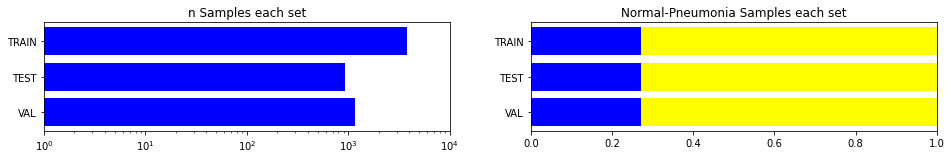

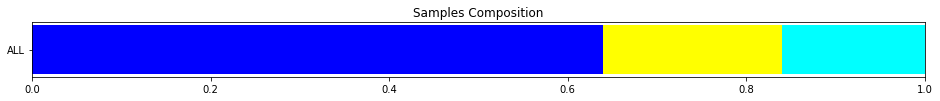

In [30]:
#@title code for samples composition
fig = plt.figure(figsize=(16,2))

ax = fig.add_subplot(1,2,1)
ax.barh(['VAL'], [NB_VAL_SAMPLES], color='#0000ff')
ax.barh(['TEST'], [NB_TEST_SAMPLES], color='#0000ff')
ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES], color='#0000ff')
ax.set_xscale('log')
ax.set_xlim((1,1e4))
ax.set_title('n Samples each set');

ax = fig.add_subplot(1,2,2)
ax.barh(['VAL'], [NB_VAL_SAMPLES_N/NB_VAL_SAMPLES], color='#0000ff')
ax.barh(['VAL'], [NB_VAL_SAMPLES_P/NB_VAL_SAMPLES], color='#ffff00',
        left=[NB_VAL_SAMPLES_N/NB_VAL_SAMPLES])
ax.barh(['TEST'], [NB_TEST_SAMPLES_N/NB_TEST_SAMPLES], color='#0000ff')
ax.barh(['TEST'], [NB_TEST_SAMPLES_P/NB_TEST_SAMPLES], color='#ffff00', 
        left=[NB_TEST_SAMPLES_N/NB_TEST_SAMPLES])
ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES], color='#0000ff')
ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_P/NB_TRAIN_SAMPLES], color='#ffff00', 
        left=[NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES])
ax.set_xlim((0,1))
ax.set_title('Normal-Pneumonia Samples each set');

fig = plt.figure(figsize=(16,1))
ax = fig.add_subplot(1,1,1)
NB_TOTAL_SAMPLES = NB_TEST_SAMPLES + NB_TRAIN_SAMPLES + NB_VAL_SAMPLES
ax.barh(['ALL'], [NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES], color='#0000ff')
ax.barh(['ALL'], [NB_VAL_SAMPLES/NB_TOTAL_SAMPLES], color='#ffff00',
        left=[NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES])
ax.barh(['ALL'], [NB_TEST_SAMPLES/NB_TOTAL_SAMPLES], color='#00ffff',
        left=[(NB_TRAIN_SAMPLES+NB_VAL_SAMPLES)/NB_TOTAL_SAMPLES])
ax.set_xlim((0,1))
ax.set_title('Samples Composition');

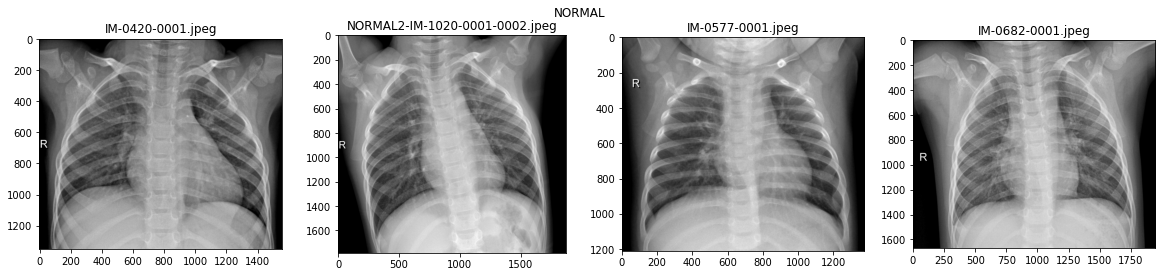

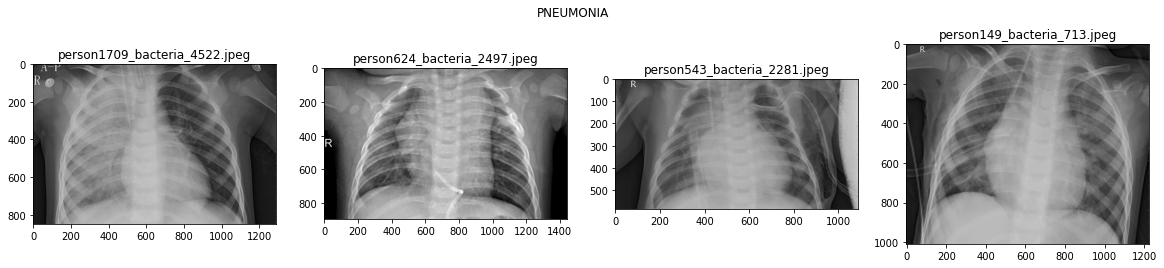

In [28]:
#@title code for show image

img_normal = []
img_pneumonia = []
for img_dir in [test_img_dir, train_img_dir, val_img_dir]:
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'NORMAL')):
    for filename in filenames:
        img_normal.append(os.path.join(dirname, filename))
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'PNEUMONIA')):
    for filename in filenames:
        img_pneumonia.append(os.path.join(dirname, filename))

fig, ax = plt.subplots(1,4, figsize=(20, 4))
ax = ax.flatten()
plt.suptitle("NORMAL")
for i, j in enumerate(np.random.randint(len(img_normal), size=4).tolist()):
  ax[i].imshow(load_img(img_normal[j]))
  ax[i].set_title(img_normal[j].split('/')[-1]);

fig, ax = plt.subplots(1,4, figsize=(20, 4))
ax = ax.flatten()
plt.suptitle("PNEUMONIA")
for i, j in enumerate(np.random.randint(len(img_pneumonia), size=4).tolist()):
  ax[i].imshow(load_img(img_pneumonia[j]))
  ax[i].set_title(img_pneumonia[j].split('/')[-1]);

From the pictures, I can tell you there are differences in the rib cage shape of the patient who has pneumonia compared to normal chest.
- Somehow the x-ray return more clear image in normal person and foggy image in infected.
- Also, normal chest is relatively symetric between the right and the left part.

# Data Preparation

- resize
- ImageDataGenerator might causes "bleeding" and crop important feature

# Data Generator

ImageDataGenerator

In [40]:
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 20

In [41]:
train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=10,  # degrees
                   zoom_range=0.15,
                   width_shift_range=0.15,  # per cent width
                   height_shift_range=0.15,  # per cent height
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.2,
                   )

train_generator = train_datagen.flow_from_directory(
                                   train_img_dir,
                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary',
                                   )

val_generator = ImageDataGenerator(rescale=1./255)\
                    .flow_from_directory(
                        val_img_dir,
                         target_size=(IMG_WIDTH, IMG_HEIGHT),
                         batch_size=BATCH_SIZE,
                         class_mode='binary',
                         )

test_generator = ImageDataGenerator(rescale=1./255)\
                      .flow_from_directory(
                          test_img_dir,
                          target_size=(IMG_WIDTH, IMG_HEIGHT),
                          batch_size=BATCH_SIZE,
                          class_mode='binary',
                          )

Found 3746 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 938 images belonging to 2 classes.


In [42]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Create Model

In [43]:
inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Flatten()(model)
model = Dense(activation='relu', units=128)(model)
outputs = Dense(activation='sigmoid', units=1)(model)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               5308

# Fit Model

In [44]:
EPOCHS = 20

history = model.fit_generator(
              train_generator,
              steps_per_epoch=NB_TRAIN_SAMPLES//BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=val_generator,
              validation_steps=NB_VAL_SAMPLES//BATCH_SIZE+1,
              # callbacks=,
              )

Train for 37 steps, validate for 1 steps
Epoch 1/20
37/37 [==============================] - 91s 2s/step - loss: 0.6606 - accuracy: 0.7079 - val_loss: 0.3732 - val_accuracy: 0.8500
Epoch 2/20
37/37 [==============================] - 91s 2s/step - loss: 0.3877 - accuracy: 0.8236 - val_loss: 0.1851 - val_accuracy: 0.9200
Epoch 3/20
37/37 [==============================] - 92s 2s/step - loss: 0.3063 - accuracy: 0.8637 - val_loss: 0.2128 - val_accuracy: 0.9100
Epoch 4/20
37/37 [==============================] - 91s 2s/step - loss: 0.3147 - accuracy: 0.8642 - val_loss: 0.1656 - val_accuracy: 0.9300
Epoch 5/20
37/37 [==============================] - 96s 3s/step - loss: 0.2574 - accuracy: 0.8919 - val_loss: 0.1154 - val_accuracy: 0.9800
Epoch 6/20
37/37 [==============================] - 99s 3s/step - loss: 0.2889 - accuracy: 0.8777 - val_loss: 0.1892 - val_accuracy: 0.8800
Epoch 7/20
37/37 [==============================] - 92s 2s/step - loss: 0.2544 - accuracy: 0.8944 - val_loss: 0.1225 - 

KeyboardInterrupt: 

In [36]:
score = model.evaluate(test_generator,
                       steps=NB_TEST_SAMPLES//BATCH_SIZE)

46/46 [==============================] - 14s 294ms/step - loss: 0.1624 - accuracy: 0.9413


In [37]:
# save model
timestamp = datetime.strftime(datetime.now(), "%m%d_%H%m")  #month day hour min
model_fname = f"sequential_{timestamp}"; display(model_fname)
model.save(model_fname, save_format='h5')

'sequential_0405_0604'

In [38]:
log = {}
log['datetime'] = datetime.now()
log['history'] = history.history
log['score'] = {'loss':score[0], 'accuracy':score[1]}
log['params'] = {'epoch':EPOCHS, 'batch_size':BATCH_SIZE,
                 'optimizer':optimizer, 'loss':loss, 'metrics':metrics}
# json.dump('log.csv',log)

# Evaluation

Evaluation Criteria :

- Still overfit for epoch 20
- Try higher batch_size, lower lr, higher epoch

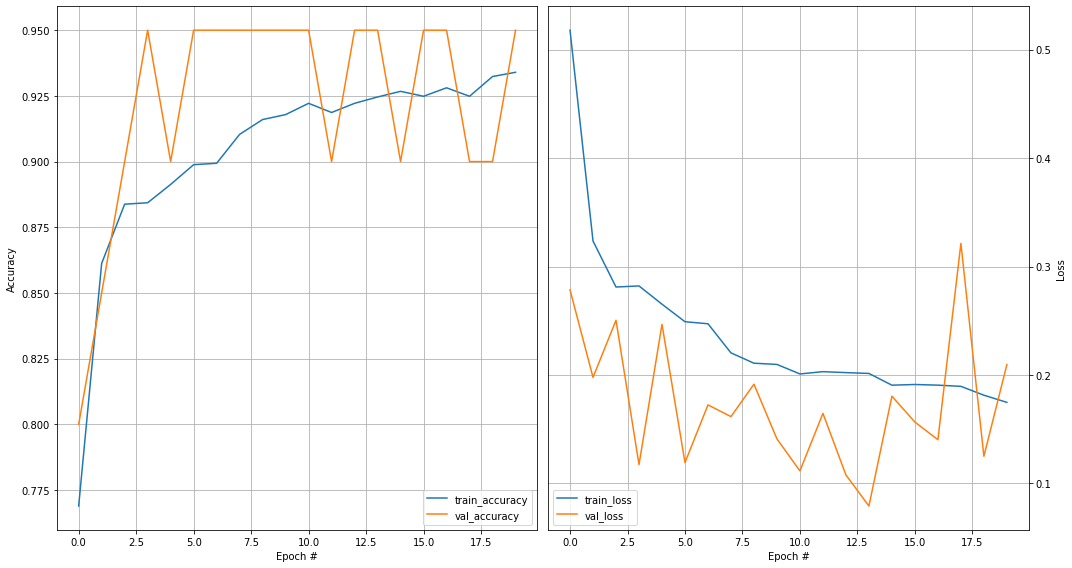

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=False)

ax[0].plot(history.epoch, history.history['accuracy'], label='train_accuracy')
ax[0].plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch #')
ax[0].grid()
# ax[0].set_xlim(30,120)
# ax[0].set_ylim(0,.3)

ax[1].plot(history.epoch, history.history['loss'], label='train_loss')
ax[1].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[1].legend(loc='lower left')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch #')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].grid()
# ax[0].set_xlim(30,120)
# ax[0].set_ylim(0,.3)

plt.tight_layout();

In [0]:
# try image from other source

url_list = [
            # https://radiopaedia.org/cases/normal-chest-x-ray
            "https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_jumbo.jpg",
            # https://radiopaedia.org/cases/normal-chest-x-ray-1
            "https://prod-images-static.radiopaedia.org/images/8686421/17baee9bfb9018e3d109ec63cb380e_jumbo.jpeg",
            # https://radiopaedia.org/cases/lobar-pneumonia?lang=us
            "https://prod-images-static.radiopaedia.org/images/27547404/4e1dc09c3abe03a3efb72d494ddb6f_jumbo.jpeg",
            # https://radiopaedia.org/cases/round-pneumonia-8?lang=us
            "https://prod-images-static.radiopaedia.org/images/2394007/5d72614a0bb470df028956a4d303b0_jumbo.jpg", 
            ]

for url in url_list:

  response = requests.get(url)
  # img = Image.open(BytesIO(response.content))
  img = load_img(BytesIO(response.content), target_size=(IMG_WIDTH, IMG_HEIGHT))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)

  classes = model.predict(img, batch_size=10)
  print(classes[0][0])
  if classes[0][0]>0.5:
    print(url + " is NORMAL case")
  else:
    print(url + " is PNEUMONIA case")


# uploaded = files.upload()

# for fn in uploaded.keys():

#   path = '/content/' + fn
#   img = load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
#   img = img_to_array(img)
#   img = np.expand_dims(img, axis=0)

  # classes = model.predict(img, batch_size=10)
  # print(classes[0][0])
  # if classes[0][0]>0.5:
  #   print(fn + " is NORMAL case")
  # else:
  #   print(fn + " is PNEUMONIA case")